# KNN model using caret in R
#### Achyuthuni Sri Harsha

Implementation of k_ nearest neighbour using caret package in R.

Inspired from dataaspirant blog at https://dataaspirant.com/2017/01/09/knn-implementation-r-using-caret-package/

Raw code for the model can be found at https://github.com/HarshaAsh/DataAspirant_codes/blob/master/K-nearest-neighbor%20classifier/Knn-Classifier-R-caret/wine_origin.r

## Wine Recognition Problem Statement:

To model a classifier for classifying the origin of the wine. The classifier should predict whether the wine is from origin “1” or “2” or “3”.

For this experiment, wines were grown in the same region in Italy but derived from 3 different cultivars. The analysis determined the quantities of 13 constituents found in each of the three types of wines. We have a dataset with 13 attributes having continuous values and one attribute with class labels of wine origin.


Using the wine dataset our task is to build a model to recognize the origin of the wine.

The 13 Attributes of the dataset are:
1. Alcohol
2. Malic acid
3. Ash
4. Alkalinity of ash
5. Magnesium
6. Total phenols
7. Flavanoids
8. Nonflavonoids phenols
9. Proanthocyanins
10. Color intensity
11. Hue
12. OD280/OD315 of diluted wines
13. Proline

The attribute with the class label is at index 1. It consists of 3 values 1, 2 & 3. These class labels are going to be predicted by our KNN model.

In [2]:
#importing libraries
options(warning = -1)

library(caret)
library(dplyr)

options(warning = 0)

## Importing data
The original owners of this dataset are Forina, M. et al. , PARVUS, Institute of Pharmaceutical and Food Analysis and Technologies, Via Brigata Salerno, 16147 Genoa, Italy. This wine dataset is hosted as open data on UCI machine learning repository (https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data).

In [3]:
dataurl <- "https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data"
download.file(url = dataurl, destfile = "wine.data")
wine_df <- read.csv("wine.data", header = FALSE)
colnames(wine_df) <- c('class', 'alcohol', 'malic_acid', 'ash', 'alkalinity','magnesium', 'phenols', 'flavanoids',
                       'nonflavonoids', 'proanthocyanins', 'color_intensity', 'hue', 'fraction_OD280', 'proline')

#introducing a few NA values to spice things up.
for(i in 1:14){
    set.seed(i+1)
    wine_df[sample(1:100, 1),sample(1:14, 1)] <- NA
}

head(wine_df)

class,alcohol,malic_acid,ash,alkalinity,magnesium,phenols,flavanoids,nonflavonoids,proanthocyanins,color_intensity,hue,fraction_OD280,proline
1,14.23,1.71,NA,15.6,127,2.80,3.06,NA,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
1,13.16,2.36,NA,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
1,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450


## Handling NA
1. Check whether any NA value exists or not
2. If so, check if they exist in the classification target variable(Remove the columns of they do)
3. Check if they exist in any features. (replace them with their mean values)

In [4]:
anyNA(wine_df)

[1] TRUE

In [5]:
anyNA(wine_df$class)

[1] TRUE

In [6]:
wine_df <- wine_df %>% 
    filter(!is.na(class))

In [7]:
anyNA(wine_df$class)
anyNA(wine_df)
indx <- which(is.na(wine_df), arr.ind=TRUE)
indx

[1] FALSE

[1] TRUE

row,col
69,3
71,3
81,3
1,4
3,4
64,4
21,7
31,8
1,9
20,9


In [8]:
colmeans <- colMeans(wine_df, na.rm=TRUE)
wine_df[indx] <- colmeans[indx[,2]]

## Data Slicing

Data slicing is a step to split data into train and test set. 

Training data set can be used specifically for our model building. 

Test dataset should not be mixed up while building model. Even during standardization, we should not standardize our test set.

The split for test and training is taken to be 70%:30%. Thats why the p value is 0.7. createDataPartition is a method from caret package.

In [9]:
set.seed(512)
intrain <- createDataPartition(y = wine_df$class, p= 0.7, list = FALSE)
training <- wine_df[intrain,]
testing <- wine_df[-intrain,]

Checking the dimensions of the data

In [10]:
print("training data sets- row:col")
dim(training)
print("test data sets- row:col")
dim(testing)

[1] "training data sets- row:col"


[1] 125  14

[1] "test data sets- row:col"


[1] 52 14

## Pre processing of training data

A summary of our data set is as follows

In [11]:
summary(wine_df)

     class          alcohol        malic_acid        ash          alkalinity  
 Min.   :1.000   Min.   :11.03   Min.   :0.74   Min.   :1.360   Min.   :10.6  
 1st Qu.:1.000   1st Qu.:12.36   1st Qu.:1.61   1st Qu.:2.220   1st Qu.:17.2  
 Median :2.000   Median :13.05   Median :1.89   Median :2.360   Median :19.5  
 Mean   :1.938   Mean   :13.00   Mean   :2.36   Mean   :2.367   Mean   :19.5  
 3rd Qu.:3.000   3rd Qu.:13.68   3rd Qu.:3.10   3rd Qu.:2.550   3rd Qu.:21.5  
 Max.   :3.000   Max.   :14.83   Max.   :5.80   Max.   :3.230   Max.   :30.0  
   magnesium         phenols        flavanoids    nonflavonoids   
 Min.   : 70.00   Min.   :0.980   Min.   :0.340   Min.   :0.1300  
 1st Qu.: 88.00   1st Qu.:1.740   1st Qu.:1.200   1st Qu.:0.2700  
 Median : 98.00   Median :2.350   Median :2.110   Median :0.3400  
 Mean   : 99.82   Mean   :2.292   Mean   :2.019   Mean   :0.3647  
 3rd Qu.:107.00   3rd Qu.:2.800   3rd Qu.:2.860   3rd Qu.:0.4400  
 Max.   :162.00   Max.   :3.880   Max.   :5.0

From above summary statistics, it shows us that all the attributes have a different range. So, we need to standardize our data. We can standardize data using caret’s preProcess() method.

We are passing 2 values in our “preProcess” parameter “center” & “scale”. These two help for centering and scaling the data. After preProcessing these convert our training data with mean value as approximately “0” and standard deviation as “1”.

In [12]:
pre_process <- c("center", "scale")

Our target variable consists of 3 values 1, 2, 3. 

These should considered as categorical variables. To convert these to categorical variables, we can convert them to factors.

In [13]:
training[['class']] = factor(training[['class']])

We are setting 3 parameters of trainControl() method. The “method” parameter holds the details about resampling method. We can set “method” with many values like  “boot”, “boot632”, “cv”, “repeatedcv”, “LOOCV”, “LGOCV” etc. For this tutorial, let’s try to use repeatedcv i.e, repeated cross-validation.

The “number” parameter holds the number of resampling iterations. The “repeats ” parameter contains the complete sets of folds to compute for our repeated cross-validation. We are using setting number =10 and repeats =3. This trainControl() methods returns a list.

In [14]:
trctrl <- trainControl(method = "repeatedcv", number = 10, repeats = 3)

The class ~ . denotes a formula for using all attributes in our classifier and class as the target variable.

We could select attributes by adding them for the formulae

In [15]:
attributes_formulae <- class ~ alcohol + malic_acid + ash + alkalinity + magnesium + phenols + flavanoids + 
                    nonflavonoids + proanthocyanins + color_intensity + hue + fraction_OD280 + proline

## Training the Knn model

For training knn classifier, train() method should be passed with “method” parameter as “knn”. 
The “tuneLength” parameter holds an integer value. This is for tuning our algorithm.

In [16]:
set.seed(3333)
knn_fit <- train(attributes_formulae, data = training, method = "knn",
 trControl=trctrl,
 preProcess = pre_process,
 tuneLength = 10)

You can check the result of our train() method. We are saving its results in a knn_fit variable.

In [17]:
knn_fit

k-Nearest Neighbors 

125 samples
 13 predictor
  3 classes: '1', '2', '3' 

Pre-processing: centered (13), scaled (13) 
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 113, 114, 112, 113, 112, 112, ... 
Resampling results across tuning parameters:

  k   Accuracy   Kappa    
   5  0.9522117  0.9280460
   7  0.9606227  0.9407156
   9  0.9548840  0.9322948
  11  0.9651709  0.9477619
  13  0.9576618  0.9362287
  15  0.9550977  0.9326388
  17  0.9452076  0.9176669
  19  0.9443445  0.9165907
  21  0.9438783  0.9159106
  23  0.9464730  0.9197424

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 11.

Its showing Accuracy and Kappa metrics result for different k value. From the results, it automatically selects best k-value. Here, our training model is choosing k = 11 as its final value.

We can see variation in Accuracy w.r.t K value by plotting these in a graph.

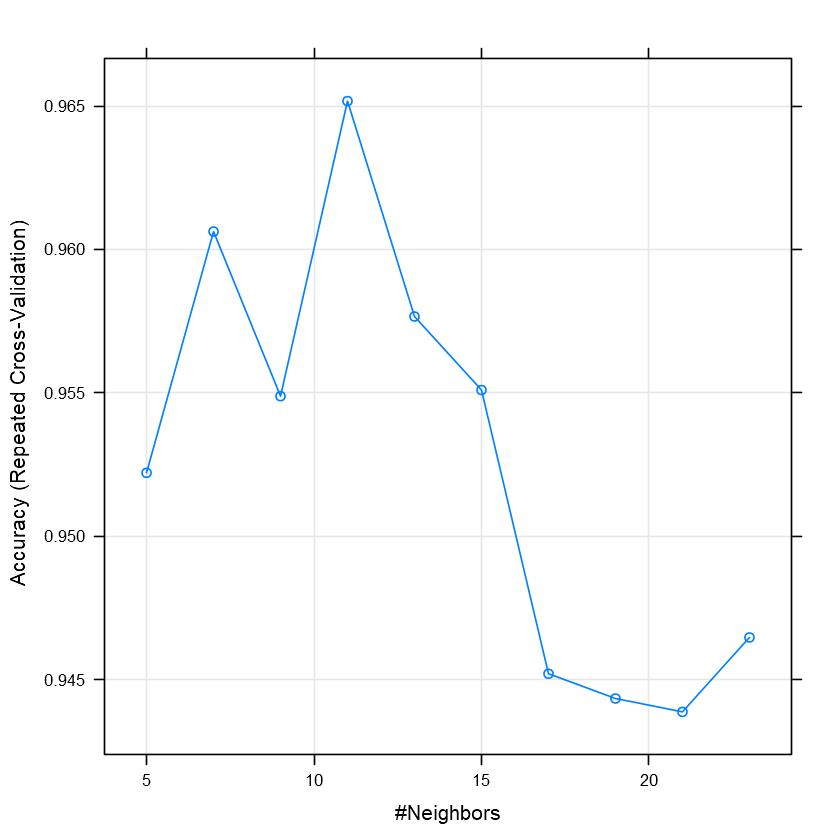

In [18]:
plot(knn_fit) 

## Test Set Prediction
Now, our model is trained with K value as 11. We are ready to predict classes for our test set. We can use predict() method.

caret package provides predict() method for predicting results. We are passing 2 arguments. The first parameter is our trained model and second parameter “newdata” holds our testing data frame. The predict() method returns a list, we are saving it in a test_pred variable.

In [19]:
test_pred <- predict(knn_fit, newdata = testing)
testing %>%
    mutate(pred = test_pred) %>% 
    select(class, pred)

class,pred
1,1
1,1
1,1
1,1
1,1
1,1
1,1
1,1
1,1
1,1


## Accuracy

Using confusion matrix, we can print statistics of our results. It shows that our model accuracy for test set is 96.15%.

In [20]:
testing[['class']] <- factor(testing[['class']])
confusionMatrix(test_pred, testing$class)

Confusion Matrix and Statistics

          Reference
Prediction  1  2  3
         1 17  2  0
         2  0 19  0
         3  0  0 14

Overall Statistics
                                          
               Accuracy : 0.9615          
                 95% CI : (0.8679, 0.9953)
    No Information Rate : 0.4038          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9418          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3
Sensitivity            1.0000   0.9048   1.0000
Specificity            0.9429   1.0000   1.0000
Pos Pred Value         0.8947   1.0000   1.0000
Neg Pred Value         1.0000   0.9394   1.0000
Prevalence             0.3269   0.4038   0.2692
Detection Rate         0.3269   0.3654   0.2692
Detection Prevalence   0.3654   0.3654   0.2692
Balanced Accuracy      0.9714   0.9524   1.0000